# First iteration of tree-based models.

The hyperparameter optization process will be the following:
1. Train with default hyperaparameters.
2. Identify bias and variance.
3. Choose first range for hyperparameters based on results.
4. Train n models using HalvingRandomSearchCV from scikit learn.
5. Pick the regions of the hyperparameter space that yield the best results.
6. Centre the hyperparameter search on those regions and iterate.

The scoring will consist in:
1. Numerical scores for the testing subset: recall, precision, roc_auc, f1.
2. Numerical scores for the whole data: recall, precision, roc_auc, f1.
2. Visualization of the ROC curve for the whole data.
4. Confusion matrix for the whole data.

In this way we can see if each model over/underfits, comparing the test and total scores. Also, the ROC curve and the confusion matrix will show how each model is performing in the whole dataset.


In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
# For random number generation
from scipy.stats import randint, uniform

from sklearn.experimental import enable_halving_search_cv # Allow importing the experimental HalvingGridSearchCV

# Metrics and auxiliar libraries from sklearn.
from sklearn.model_selection import train_test_split, HalvingRandomSearchCV, RepeatedStratifiedKFold, HalvingGridSearchCV

# Some auxiliary functions for scoring.
import submission.scoring_utils as scoring_utils

#DEV
import importlib as imp


In [2]:
# Import the dataframe cleaned and encoded during the feature importance process.
df_encoded = pd.read_csv('../data/df_encoded_interest.csv')

In [3]:
target = 'Default'
features_encoded = [feature for feature in df_encoded.columns if feature not in target]
# Our target and features are the same that we employed during the importance analysis.
print(f"Target: {target}")
print(f"Features: {features_encoded}")

Target: Default
Features: ['NAICS', 'Term', 'NewExist', 'FranchiseCode', 'RevLineCr', 'LowDoc', 'GrAppv', 'SBA_Appv', 'isNewBusiness', 'isFranchise', 'SBARatio', 'InterestRate', 'NAICS_i_0', 'NAICS_i_11', 'NAICS_i_21', 'NAICS_i_22', 'NAICS_i_23', 'NAICS_i_31', 'NAICS_i_32', 'NAICS_i_33', 'NAICS_i_42', 'NAICS_i_44', 'NAICS_i_45', 'NAICS_i_48', 'NAICS_i_49', 'NAICS_i_51', 'NAICS_i_52', 'NAICS_i_53', 'NAICS_i_54', 'NAICS_i_55', 'NAICS_i_56', 'NAICS_i_61', 'NAICS_i_62', 'NAICS_i_71', 'NAICS_i_72', 'NAICS_i_81', 'NAICS_i_92', 'UrbanRural_0', 'UrbanRural_1', 'UrbanRural_2']


In [4]:
# This split will be used in every model, so that they are scored against the same subset.
X_train, X_test, y_train, y_test = train_test_split(df_encoded[features_encoded], df_encoded[target], train_size = .9)
# Complete datasets
X_total = df_encoded[features_encoded]
y_total = df_encoded[target]

### Single Decision Tree Classifier

In [5]:
# Default check to identify bias/variance
from sklearn.tree import DecisionTreeClassifier

default_tree = DecisionTreeClassifier()
default_tree.fit(X_train, y_train)

yhat_train = default_tree.predict(X_train)
yhat_test = default_tree.predict(X_test)

default_tree_score = pd.concat((
    scoring_utils.get_metrics(y_train, yhat_train, "Default Tree Train"),
    scoring_utils.get_metrics(y_test, yhat_test, "Default Tree Test")
    ))

default_tree_score

,Recall,Precision,ROC,F1
Default Tree Train,0.996657,0.999978,0.998326,0.998315
Default Tree Test,0.768587,0.766740,0.860066,0.767663


In [6]:
default_tree.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

It does overfit! Let's decrease the variance by tuning the hyperparameters.

In [45]:

# Grid of parameters for a single tree
param_grid = [
    {
        "min_samples_split": randint(100, 200),
        "max_depth": randint(14, 18)
    }
]

# Cross validation in 3 folds for our grid search parameter selection.
# It must be consistent across the folds, so the random state has to be fixed.
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=9)

single_tree_search = HalvingRandomSearchCV(
    estimator=DecisionTreeClassifier(class_weight='balanced'),
    param_distributions=param_grid,
    scoring='f1',
    cv=cv,
    n_jobs=-1,
    n_candidates=1000
)

single_tree_search.fit(X_train, y_train)


HalvingRandomSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=3, random_state=9),
                      estimator=DecisionTreeClassifier(class_weight='balanced'),
                      n_candidates=1000, n_jobs=-1,
                      param_distributions=[{'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x13f09f090>,
                                            'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x2f904e0d0>}],
                      scoring='f1')

In [46]:
scoring_utils.get_best_kernels(single_tree_search.cv_results_)

,params,mean_test_score,mean_fit_time
kernel,,,
15_151,"{'max_depth': 15, 'min_samples_split': 151}",0.707424,0.089776
15_146,"{'max_depth': 15, 'min_samples_split': 146}",0.706066,0.092167
15_146,"{'max_depth': 15, 'min_samples_split': 146}",0.666545,0.025832
15_151,"{'max_depth': 15, 'min_samples_split': 151}",0.664056,0.027384
15_151,"{'max_depth': 15, 'min_samples_split': 151}",0.663991,0.027864
...,...,...,...
14_158,"{'max_depth': 14, 'min_samples_split': 158}",0.143862,0.001274
14_175,"{'max_depth': 14, 'min_samples_split': 175}",0.143862,0.002835
15_140,"{'max_depth': 15, 'min_samples_split': 140}",0.143862,0.002261


In [32]:
single_tree_search.best_estimator_.get_params()

{'ccp_alpha': 0.0,
 'class_weight': {0: 0.2, 1: 0.8},
 'criterion': 'gini',
 'max_depth': 14,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 148,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [33]:
len(df_encoded[df_encoded[target] == 1])

149260

In [40]:

weights = [.1, .15, .2, .25, .3]

for weight in weights:
    print(f"\nTraining for weight: {weight}...")
    model = DecisionTreeClassifier(
        max_depth= 15,
        min_samples_split=130,
        class_weight={0: weight, 1:(1-weight)}
    )
    
    model.fit(X_train, y_train)

    yhat_test = model.predict(X_test)
    yhat_train = model.predict(X_train)
    yhat_total = model.predict(X_total)

    score = pd.concat([
        scoring_utils.get_metrics(y_train, yhat_train, "Train"),
        scoring_utils.get_metrics(y_test, yhat_test, "Test"),
        scoring_utils.get_metrics(y_total, yhat_total, "Total")
    ])

    print(score)

    print(f"We obtained a profit of ${scoring_utils.get_profit(X_total, y_total, yhat_total):,.2f}")





Training for weight: 0.1...


KeyboardInterrupt: 

In [47]:
# Let's use the best estimator to obtain test and overall scores 
single_tree_model = single_tree_search.best_estimator_

yhat_test = single_tree_model.predict(X_test)
yhat_total = single_tree_model.predict(X_total)

In [48]:
single_tree_test_score = scoring_utils.get_metrics(y_test, yhat_test, "Single Tree Test")
single_tree_total_score = scoring_utils.get_metrics(y_total, yhat_total, "Single Tree Total")

single_tree_score = pd.concat((single_tree_test_score, single_tree_total_score))
single_tree_score

,Recall,Precision,ROC,F1
Single Tree Test,0.925316,0.684166,0.918399,0.786675
Single Tree Total,0.940500,0.694942,0.927531,0.799286


In [49]:
print(f"We obtained a profit of ${scoring_utils.get_profit(X_total, y_total, yhat_total):,.2f}")

We obtained a profit of $6,629,199,765.90


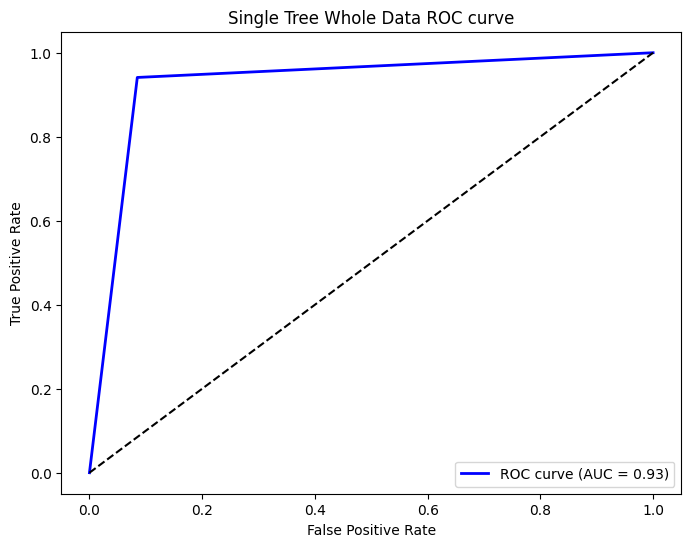

In [12]:
scoring_utils.get_roc_plot(y_total, yhat_total, "Single Tree Whole Data")

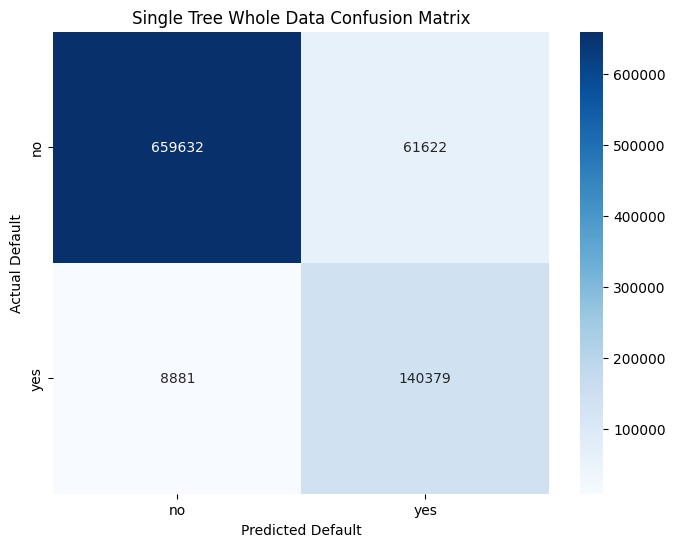

In [50]:
scoring_utils.get_confusion_matrix(y_total, yhat_total, "Single Tree Whole Data")

### Bagging classifier

In [ ]:
# Default check to identify bias/variance
from sklearn.ensemble import BaggingClassifier

default_bagging = BaggingClassifier(DecisionTreeClassifier(), n_jobs=-1)
default_bagging.fit(X_train, y_train)

yhat_train = default_bagging.predict(X_train)
yhat_test = default_bagging.predict(X_test)

default_bagging_score = pd.concat((
    scoring_utils.get_metrics(y_train, yhat_train, "Default Bagging Train"),
    scoring_utils.get_metrics(y_test, yhat_test, "Default Bagging Test")
    ))

default_bagging_score

In [ ]:
default_bagging.get_params()

In [ ]:

# Grid of parameters for a bagging model
param_grid = [
    {
        "max_samples": [.8, .9, 1.0]
    }
]

# Cross validation in 3 folds for our grid search parameter selection.
# It must be consistent across the folds, so the random state has to be fixed.
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=9)

bagging_search = HalvingGridSearchCV(
    estimator=BaggingClassifier(n_estimators=10, estimator=single_tree_model),
    param_grid=param_grid,
    scoring='recall',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

bagging_search.fit(X_train, y_train)


In [ ]:
scoring_utils.get_best_kernels(bagging_search.cv_results_)

In [ ]:
bagging_model = bagging_search.best_estimator_

yhat_test = bagging_model.predict(X_test)
yhat_total = bagging_model.predict(X_total)

In [ ]:
bagging_test_score = scoring_utils.get_metrics(y_test, yhat_test, "Bagging Test")
bagging_total_score = scoring_utils.get_metrics(y_total, yhat_total, "Bagging Total")

bagging_score = pd.concat((bagging_test_score, bagging_total_score, single_tree_score))
bagging_score

In [ ]:
print(f"We obtained a profit of ${scoring_utils.get_profit(X_total, y_total, yhat_total):,.2f}")

In [ ]:
scoring_utils.get_roc_plot(y_total, yhat_total, "Bagging Whole Data")

In [ ]:
scoring_utils.get_confusion_matrix(y_total, yhat_total, "Bagging Whole Data")

### Random forest

In [ ]:
# Default to check bias/variance
from sklearn.ensemble import RandomForestClassifier

default_forest = RandomForestClassifier(n_jobs=-1).fit(X_train, y_train)

yhat_train = default_forest.predict(X_train)
yhat_test = default_forest.predict(X_test)

default_forest_score = pd.concat((
    scoring_utils.get_metrics(y_train, yhat_train, 'Default Forest Train'),
    scoring_utils.get_metrics(y_test, yhat_test, 'Default Forest Test')
))

default_forest_score


In [ ]:
default_forest.get_params()

In [ ]:
# {'max_depth': 14, 'min_samples_split': 109} # One of my best trees!!!!!

param_grid = {
    'max_depth': [50, 100, 150], # This has a smaller effect, but 100 seems to work out fine.
    'min_samples_split': [10, 100, 1000] # This should be around 100
}

# Cross validation in 3 folds for our grid search parameter selection.
# It must be consistent across the folds, so the random state has to be fixed.
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=9)

random_forest_search = HalvingGridSearchCV(
    estimator=RandomForestClassifier(n_estimators=50, max_features=1.0, class_weight='balanced'),
    param_grid=param_grid,
    scoring='recall',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

random_forest_search.fit(X_train, y_train)


In [ ]:
scoring_utils.get_best_kernels(random_forest_search.cv_results_)

In [ ]:
random_forest = random_forest_search.best_estimator_

yhat_test = random_forest.predict(X_test)
yhat_total = random_forest.predict(X_total)

In [ ]:
forest_test_score = scoring_utils.get_metrics(y_test, yhat_test, "Random Forest Test")
forest_total_score = scoring_utils.get_metrics(y_total, yhat_total, "Random Forest Total")

forest_score = pd.concat((forest_test_score, forest_total_score, bagging_score))
forest_score

In [ ]:
print(f"We obtained a profit of ${scoring_utils.get_profit(X_total, y_total, yhat_total):,.2f}")

In [ ]:
scoring_utils.get_roc_plot(y_total, yhat_total, "Forest Whole Data")

In [ ]:
scoring_utils.get_confusion_matrix(y_total, yhat_total, "Random Forest Whole Data")

### Boosting

In [ ]:
import xgboost as xgb

In [ ]:
xgbmodel = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=100,
 verbosity=2,
 max_depth=11,
 min_child_weight=10,
 gamma=0.1,
 subsample=0.9,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 scale_pos_weight=3.3,
 seed=27)

xgb_param = xgbmodel.get_xgb_params()
xgtrain = xgb.DMatrix(X_train.values, label=y_train.values)
cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=xgbmodel.get_params()['n_estimators'], nfold=5,
metrics='auc', early_stopping_rounds=50)
xgbmodel.set_params(n_estimators=cvresult.shape[0])

xgbmodel.fit(X_train, y_train, eval_metric='auc')



In [ ]:
yhat_train = xgbmodel.predict(X_train)
yhat_test = xgbmodel.predict(X_test)

cv_boost_score = pd.concat((
    scoring_utils.get_metrics(y_train, yhat_train, 'CV Boosting Train'),
    scoring_utils.get_metrics(y_test, yhat_test, 'CV Boosting Test')
))

cv_boost_score

In [ ]:
yhat_total = xgbmodel.predict(X_total)
scoring_utils.get_confusion_matrix(y_total, yhat_total, 'CV Boosting')

In [ ]:
print(f"We obtained a profit of ${scoring_utils.get_profit(X_total, y_total, yhat_total):,.2f}")

In [ ]:
print(f"The maximum is ${scoring_utils.get_profit(X_total, y_total, y_total):,.2f}")

# This fuckers works worse. Check if there's time

In [ ]:
from xgboost import XGBClassifier

weights = [3.3, 3.5, 3.7, 3.9]

for weight in weights:
    print(f"\nTraining for weight: {weight}...")
    model = xgb.XGBClassifier(
        learning_rate =0.1,
        n_estimators=100,
        verbosity=2,
        max_depth=11,
        min_child_weight=10,
        gamma=0.1,
        subsample=0.9,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        seed=27,
        scale_pos_weight=weight)
    
    model.fit(X_train, y_train)

    yhat_test = model.predict(X_test)
    yhat_train = model.predict(X_train)
    yhat_total = model.predict(X_total)

    score = pd.concat([
        scoring_utils.get_metrics(y_train, yhat_train, "Train"),
        scoring_utils.get_metrics(y_test, yhat_test, "Test"),
        scoring_utils.get_metrics(y_total, yhat_total, "Total")
    ])

    print(score)

    print(f"We obtained a profit of ${scoring_utils.get_profit(X_total, y_total, yhat_total):,.2f}")




In [ ]:
from xgboost import XGBClassifier

param_grid = [{
    'scale_pos_weight': [3, 4, 4.5, 5, 5.5, 6]
}]

cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=12)

xgbsearch = HalvingGridSearchCV(
    xgb.XGBClassifier(
        learning_rate =0.1,
        n_estimators=100,
        verbosity=2,
        max_depth=11,
        min_child_weight=10,
        gamma=0.1,
        subsample=0.9,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        seed=27),
    param_grid=param_grid,
    verbose=1,
    cv=cv,
    scoring='recall'
)

xgbsearch.fit(X_train, y_train)

In [ ]:
submission.scoring_utils.get_best_kernels(xgbsearch.cv_results_)

In [ ]:
xgbmodel = xgbsearch.best_estimator_

yhat_test = xgbmodel.predict(X_test)
yhat_total = xgbmodel.predict(X_total)

In [ ]:
xgb_test_score = submission.scoring_utils.get_metrics(y_test, yhat_test, "XGB Test")
xgb_total_score = submission.scoring_utils.get_metrics(y_total, yhat_total, "XGB Total")

xgb_score = pd.concat((xgb_test_score, xgb_total_score))
xgb_score

In [ ]:
submission.scoring_utils.get_confusion_matrix(y_total, yhat_total, "XGB")

In [ ]:
print(f"We obtained a profit of ${submission.scoring_utils.get_profit(X_total, y_total, yhat_total):,.2f}")

# Hyperopt

In [ ]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [ ]:

xgb1 = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=100,
 verbosity=2,
 max_depth=11,
 min_child_weight=10,
 gamma=0.1,
 subsample=0.9,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 scale_pos_weight=5,
 seed=27)
modelfit(xgb1, X_train, y_train)

In [ ]:
from sklearn.metrics import recall_score

In [ ]:
space={
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'max_depth': hp.quniform("max_depth", 9, 12, 1),
        'gamma': hp.uniform ('gamma', 0, 1.5),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 20, 1),
        'scale_pos_weight': 5,
        'subsample': .9
    }

In [ ]:
from xgboost import XGBClassifier

In [ ]:

xgb1 = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=100,
 verbosity=2,
 max_depth=11,
 min_child_weight=10,
 gamma=0.1,
 subsample=0.9,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 scale_pos_weight=5,
 seed=27)
modelfit(xgb1, X_train, y_train)

In [ ]:
model = XGBClassifier(
        learning_rate= 0.1, 
        max_depth = 11,
        gamma = 0.1,           
        colsample_bytree= .8,
        min_child_weight= 10,
        scale_pos_weight= 5,
        subsample= .9,
        n_estimators = 100, 
        eval_metric='recall',
        early_stopping_rounds=10 ,
        verbosity=2,
        objective= 'binary:logistic'
    )

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
def hyperparameter_tuning(space):
    model = XGBClassifier(
        learning_rate= space['learning_rate'], 
        max_depth = int(space['max_depth']),
        gamma = space['gamma'],           
        reg_alpha = int(space['reg_alpha']),
        reg_lambda = space['reg_lambda'],
        colsample_bytree=space['colsample_bytree'],
        min_child_weight=space['min_child_weight'],
        scale_pos_weight= 5,
        subsample= .9,
        n_estimators = 100, 
        eval_metric='auc',
        early_stopping_rounds=10 
    )

    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    model.fit(X_train, y_train,
            eval_set=evaluation,
            verbose=True)

    pred = model.predict(X_test)
    recall = f1_score(y_test, pred)
    print ("SCORE:", recall)
    #change the metric if you like
    return {'loss': -recall, 'status': STATUS_OK, 'model': model}

In [ ]:
submission.scoring_utils.get_profit(X_total, y_total, y_total)

In [ ]:
trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

print (best)

In [ ]:
trial = XGBClassifier(
    objective='binary:logistic',
    colsample_bytree=best['colsample_bytree'],
    gamma=best['gamma'],
    learning_rate=best['learning_rate'],
    max_depth=int(best['max_depth']),
    min_child_weight=best['min_child_weight'],
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    scale_pos_weight= 5,
    subsample= .9,
    n_estimators = 100, 
    eval_metric='auc'
)

old_version = XGBClassifier(
 learning_rate =0.1,
 n_estimators=100,
 verbosity=2,
 max_depth=11,
 min_child_weight=10,
 gamma=0.1,
 subsample=0.9,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 scale_pos_weight=5,
 seed=27)

In [ ]:

evaluation = [( X_train, y_train), ( X_test, y_test)]
    
trial.fit(X_train, y_train,
            eval_set=evaluation,
            verbose=True)

In [ ]:
yhat_test = trial.predict(X_test)
yhat_total = trial.predict(X_total)


In [ ]:
submission.scoring_utils.get_metrics(y_test, yhat_test, "Trial Test")

In [ ]:
submission.scoring_utils.get_metrics(y_total, yhat_total, "Trial Test")

In [ ]:
submission.scoring_utils.get_confusion_matrix(y_total, yhat_total, "Old model")

In [ ]:
submission.scoring_utils.get_profit(X_total, y_total, yhat_total)